<a href="https://colab.research.google.com/github/kaleem500bc/Encoder-Decoder-Translation/blob/main/Encoder_Decoder_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from io import open 
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
import string
import numpy as np
from termcolor import colored
from matplotlib import pyplot as plt

In [ ]:
# Download dataset file
!wget https://www.manythings.org/anki/deu-eng.zip -O german-eng.zip
!unzip german-eng.zip

In [ ]:
# From Pytorch tutorial with some modification "https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html"

# To eliminate all the unwanted character, eg numbers, exclamation mark etc from the sentence
def normalize(x):
  for i in range(len(x)):
    x[i] = x[i].lower().strip(string.punctuation)
    x[i] = re.sub(r"([.!?])", r" \1", x[i])
    x[i] = re.sub(r"[^a-zA-Z'.!\x7f-\xff?]+", r" ", x[i])
  return x

In [ ]:
data = open("/content/deu.txt").read()
dataSplit = data.split('\n')

In [ ]:
# First two column are source and target while the last two column are for other attributes. They are separated by tab
datasetAll =np.array([ normalize(dataSplit[i].split('\t')[:2]) for i in range(
    len(dataSplit))][:-1])

np.random.shuffle(datasetAll)

In [ ]:
# Reduce the dataset
dataset = datasetAll[:5000]
testset = datasetAll[5000:5100]

In [ ]:

# Total vocabulary in the dataset

eng_vocab = set([
         word 
         for sentence in datasetAll[:,0] # All sentences
         for word in sentence.split() 
         ])
deut_vocab = set([
         word 
         for sentence in datasetAll[:,1] # All sentences
         for word in sentence.split() 
         ])

# Actuall vocabulary size plus two for <sos> and <eos> tokens 
vocab_size = len(deut_vocab)+2

# Mapping from word corresponding unique integer
eng_word2int = { word:i+2 for i,word in enumerate(eng_vocab)}
deut_word2int = { word:i+2 for i,word in enumerate(deut_vocab)}
eng_word2int['<eos>'] = 1
deut_word2int['<sos>'] = 0
deut_word2int['<eos>'] = 1

# Mapping from unique integer to corresponding word
eng_int2word = {eng_word2int[key]:key for key in eng_word2int}
deut_int2word = {deut_word2int[key]:key for key in deut_word2int}

In [ ]:
# Encoded the dataset from words to the corresponding integer
def word2intFunc(x_y):
  x,y = x_y[0],x_y[1]
  x = torch.tensor([eng_word2int[w] for w in (x+" <eos>").split()], dtype=torch.long)
  y = torch.tensor([deut_word2int[w] for w in ("<sos> " + y + " <eos>").split()], dtype=torch.long)
  return [x,y]


encoded_data = [word2intFunc(d) for d in dataset]

encoded_testset = [word2intFunc(d) for d in testset]

In [ ]:
# Encoder model
class Encoder(nn.Module):
  def __init__(self, vocab_size,layers = 1,bdr = False, hidden=512,batch_size = 1,embedd_dim = 512):
    super().__init__()
    self.num_layers = layers
    self.batch_size = batch_size
    self.bdr = bdr
    self.hidden = hidden
    self.embedd_dim = embedd_dim
    self.Embeddings = nn.Embedding(vocab_size,embedd_dim)
    self.lstm = nn.LSTM(embedd_dim,hidden_size=hidden,num_layers=layers,batch_first=True, bidirectional=bdr)
  
  def forward(self,x,h_cell):
    seq_len = x.shape[1]
    # input shape is batch x seq_length x input_size
    x = F.relu(self.Embeddings(x))
    # input shape for lstm is batch x seq_len x input_size
    x = x.view(self.batch_size,seq_len,self.embedd_dim)
    x, h_cell = self.lstm(x,h_cell)
    return x,h_cell

# Decoder Model
class Decoder(nn.Module):
  def __init__(self, vocab_size,layers = 1,bdr = False, hidden=512,batch_size = 1,embedd_dim = 512):
    super().__init__()
    self.num_layers = layers
    self.batch_size = batch_size
    self.bdr = bdr
    self.hidden = hidden
    self.embedd_dim = embedd_dim
    self.Embeddings = nn.Embedding(vocab_size,embedd_dim)
    self.lstm = nn.LSTM(embedd_dim, hidden_size=hidden, batch_first=True, bidirectional = bdr)
    self.linear = nn.Linear(hidden, vocab_size)

  def forward(self, x, hidden):
    x = F.relu(self.Embeddings(x))
    x = x.view(self.batch_size, 1, self.embedd_dim)
    x, hidden = self.lstm(x, hidden)
    
    x =self.linear(x.view(-1))
    
    # x =  F.softmax(x)
    # print(x)
    # input()
    return x,hidden

# Initialize initial hidden state of the model
def init_hidden(model, batch_size):
  for layer,weight in zip(model.modules(),model.parameters()):
    if type(layer) == nn.LSTM:
      hidden = (torch.zeros((model.num_layers*(model.bdr+1), batch_size, model.hidden),dtype=torch.float).to("cuda"),
                torch.zeros((model.num_layers*(model.bdr+1), batch_size, model.hidden),dtype=torch.float).to("cuda"))
  return hidden

From https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
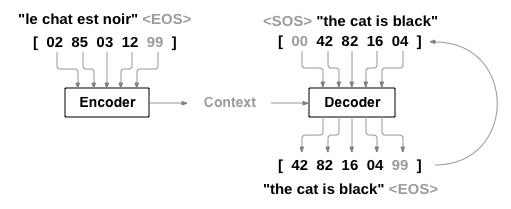

In [ ]:
encoder = Encoder(vocab_size)
decoder = Decoder(vocab_size)

# Using cross entropy loss as it is best suited for this classification problem
criterion = nn.CrossEntropyLoss()
enc_optimizer = torch.optim.SGD(encoder.parameters(), lr=0.01, momentum=0.5)
dec_optimizer = torch.optim.SGD(decoder.parameters(), lr=0.01, momentum=0.5)
encoder.to("cuda")
decoder.to("cuda")

Decoder(
  (Embeddings): Embedding(35104, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=35104, bias=True)
)

In [ ]:


# Train model with batch size of one
def train(epoch):
  loss_epoch = []
  hidden = init_hidden(encoder,1)
  for e in range(epoch):
    total_loss = 0
    b = 0
    loss = 0
    for x, y in encoded_data:
      _, context = encoder(torch.as_tensor(x, dtype=torch.long).unsqueeze(0).to("cuda"), hidden)
      dec_out = torch.tensor([0], dtype = torch.long).to("cuda")
      for i in range(len(y)-1):
        dec_out, context = decoder(dec_out.unsqueeze(0), context)
        loss += criterion(dec_out.unsqueeze(0),torch.as_tensor([y[i+1]],dtype=torch.long).to("cuda"))

        # Using strict teacher forcing: the next input to the decoder is the ground truth
        dec_out = torch.as_tensor([y[i+1]],dtype=torch.long).to("cuda")
      total_loss += loss.item()
      enc_optimizer.zero_grad()
      dec_optimizer.zero_grad()

      loss.backward()

      # optimize parameters of the encoder
      enc_optimizer.step()
      # Optimize parameters of the decoder
      dec_optimizer.step()
      
      loss = 0
    print("Loss per Epoch{}: ".format(e+1),total_loss)
    loss_epoch.append(total_loss)
  return loss_epoch

In [ ]:
epochs = 20
loss_per_epoch = train(epochs)

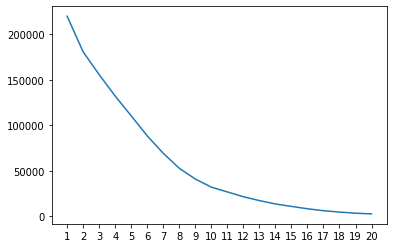

In [ ]:
# Plot loss per epoch
plt.xticks(list(range(1,epochs+1)))
plt.plot(list(range(1,epochs+1)),loss_per_epoch)

In [ ]:
# Translate source sentence x to german 
def translate(x):
  hidden = init_hidden(encoder,1)
  _, context = encoder(torch.as_tensor(x, dtype=torch.long).unsqueeze(2).to("cuda"), hidden)
  dec_out = torch.tensor([0], dtype = torch.long)
  loss = 0
  prediction_sentence = ""
  for i in range(50):
    dec_out, context = decoder(dec_out.unsqueeze(0).to("cuda"), context)
    dec_out = torch.argmax(dec_out)
    if deut_int2word[dec_out.item()] == '<eos>':
      break
    prediction_sentence += deut_int2word[dec_out.item()] + " "

  return prediction_sentence


In [ ]:
# Evaluate on testset

encoder.eval()
decoder.eval()

# Starting index in test set
start_idx = 10
print(colored("Blue is source sentence",color="blue"),colored("White is Model prediction", color="white"), colored("Red is ground truth of target", color="red"), "\n")
for i in range(start_idx,start_idx+10):
  x,y = encoded_testset[i]
  predicted_translation = translate(torch.as_tensor(x, dtype=torch.long).unsqueeze(0))

  print(colored(" ".join([eng_int2word[w.item()] for w in x]), color='blue'), colored(predicted_translation,color='white'), colored(" ".join([deut_int2word[w.item()] for w in y]), color='red'))

Blue is source sentence White is Model prediction Red is ground truth of target 

tom eventually found a job that he liked <eos> tom meinte maria haben das noch erledigen  <sos> tom fand schließlich eine arbeit die ihm gefiel <eos>
i have a cold <eos> ich habe ein schlechtes gefühl  <sos> ich bin erkältet <eos>
what i want to know is why <eos> ich weiß alles was man möchte  <sos> was ich wissen will ist warum <eos>
tom plans to be there <eos> tom wäre beinahe erwischt worden  <sos> tom will kommen <eos>
no passengers were injured <eos> niemand sah hinter leuten  <sos> fahrgäste wurden keine verletzt <eos>
introduce me to your friend over there <eos> da sind eure enkelkinder von euch  <sos> stellt mich eurer freundin da hinten vor <eos>
i want us to be friends <eos> ich möchte diesen teppich  <sos> ich möchte dass wir freundinnen sind <eos>
are you sure that tom is mary's boyfriend <eos> halte dich dass tom bald hier ist  <sos> seid ihr sicher dass tom marias freund ist <eos>
aren't you